# IEOR 4540 Final Project

**Authors:** Tiantian Chen, Yige Yang, Tong Chen, Yuyang Xu, Jiewan Yang, Ningzhou Gu

**Files Description:**
- **DM_project.ipynb**: main file for project
- **model.py**: Contains Linformer and Transformer model
- **performer_architecture.py**: Contains the Performer model architecture
- **vit_architecture.py**: Contains Transformer model architecture
- **tt.py**:testing and training the models
- **DM_Result.ipynb**: visualize results

**GPU**:
NVIDIA GeForce RTX 3090 with 24 GB of GDDR6X memory


In [ ]:
import torch
torch.cuda.is_available()

True

In [1]:
import time
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, Normalize
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from functools import partial
import math
import model
import tt
import torch.optim as optim
import performer_architecture as vip
import os

## Data Preprocessing -- CIFAR-10

The CIFAR-10 dataset consists of 32x32 color images in 10 classes, with 3 channels (RGB).

In [2]:
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, Normalize
from torch.utils.data import DataLoader, Subset

transform = Compose([
    Resize((224, 224)), 
    ToTensor(), 
    Normalize(mean=[0.486, 0.485, 0.484], std=[0.226, 0.225, 0.224])  
])


train_dataset_full = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_full = CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset_full, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_full, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data description

train_dataset_length = len(train_dataset_full)
print("Length of Training Dataset:", train_dataset_length)

test_dataset_length = len(test_dataset_full)
print("Length of Test Dataset:", test_dataset_length)


Length of Training Dataset: 50000
Length of Test Dataset: 10000


In [ ]:
images, labels = next(iter(train_loader))

print("Batch images shape:", images.shape)
print("Batch labels:", labels)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 6, 0, 8, 7, 7, 2, 4, 8, 2, 5, 1, 5, 8, 4, 9, 6, 3, 9, 2, 4, 3, 9, 9,
        8, 5, 2, 9, 0, 3, 3, 9])


In [ ]:
train_labels = [train_dataset_full[i][1] for i in range(10)]
print("First 10 labels in Training Dataset:", train_labels)

test_labels = [test_dataset_full[i][1] for i in range(10)]
print("First 10 labels in Test Dataset:", test_labels)

First 10 labels in Training Dataset: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
First 10 labels in Test Dataset: [3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


CIFAR-10 has ten labels : 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', which are repesct with number 0-9.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

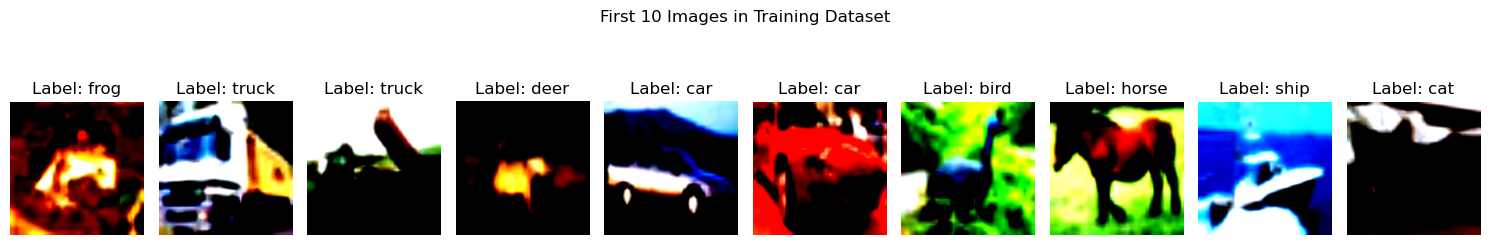

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

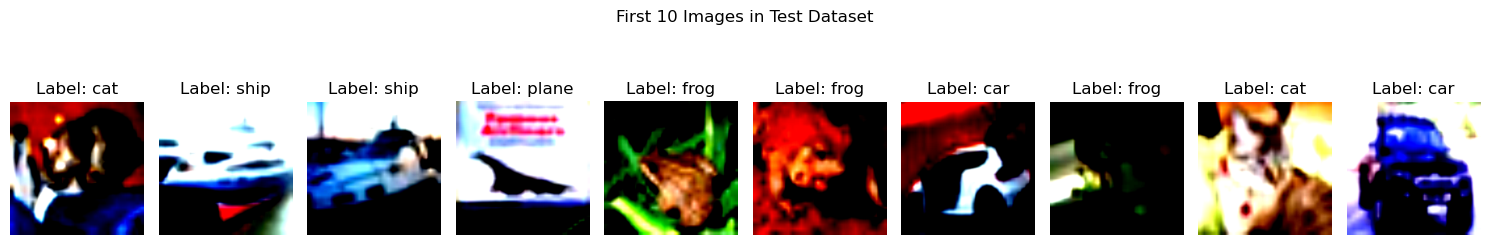

In [ ]:
import matplotlib.pyplot as plt

def show_images(dataset, title):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    plt.figure(figsize=(15, 3))
    for i in range(10):
        image, label = dataset[i]
        plt.subplot(1, 10, i + 1)
        plt.imshow(image.permute(1, 2, 0)) 
        plt.title(f"Label: {classes[label]}")  
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()  
    plt.show()

show_images(train_dataset_full, "First 10 Images in Training Dataset")

show_images(test_dataset_full, "First 10 Images in Test Dataset")



## Transformer

#### 1. Patch Embedding



*   img_size=224: the size of the input images
*   patch_size=16: the size of each patch
*   in_chans=3: the number of input channels (3 for RGB images)
*   embed_dim=768: the dimensionality of the patch embedding







In [ ]:
# Test for PatchEmbedding
model_p = model.PatchEmbedding()
img = torch.randn(32, 3, 224, 224)
patches = model_p(img)
print("Shape of output:", patches.shape)

Shape of output: torch.Size([32, 197, 768])


#### 2. Multi-Head Self-Attention


*   embed_dim :Embedding dimension
*   num_heads: Number of attention heads
*   batch_size: Batch size
*   seq_length: Length of the sequence (number of tokens in each sequence)


In [ ]:
# Test for Multi-Head Attention
embed_dim = 768
num_heads = 12
batch_size = 32
seq_length = 197


test_input = torch.rand(batch_size, seq_length, embed_dim)
mha = model.MultiHeadAttention(embed_dim, num_heads)

test_output = mha(test_input)
print("Output shape:", test_output.shape)

Output shape: torch.Size([32, 197, 768])


#### 3. Multi-Layer Perceptron



*  in_features: Size of each input sample
*  hidden_features: Size of hidden layer
*  out_features: Size of each output sample
*  dropout_rate: Dropout rate



In [ ]:
# Test for MLP
in_features = 128
hidden_features = 768
out_features = 128
dropout_rate = 0.1

batch_size = 32
test_input = torch.rand(batch_size, in_features)

mlp = model.MLP(in_features, hidden_features, out_features, dropout_rate)

test_output = mlp(test_input)
print("Output shape:", test_output.shape)

Output shape: torch.Size([32, 128])


#### 4. Encoder


*   embed_dim: Embedding dimension
*   num_heads: Number of attention heads
*   mlp_ratio: Expansion ratio for the MLP's hidden layer
*   dropout_rate: Dropout rate
|

In [ ]:

# Test for Encoder

embed_dim = 768
num_heads = 12
mlp_ratio = 4
dropout_rate = 0.1
batch_size = 32
seq_length = 197
test_input = torch.rand(batch_size, seq_length, embed_dim)


encoder_block = model.Encoder(embed_dim, num_heads, mlp_ratio, dropout_rate)


test_output = encoder_block(test_input)
print("Output shape:", test_output.shape)

Output shape: torch.Size([32, 197, 768])


#### 5. Vision Transformer

*   num_classes: Number of classes for classification
*   depth: Number of Transformer model
*   embed_dim: Embedding dimension
*   img_size: Image size (assuming square images)
*   patch_size: Size of each patch
*   in_chans: Number of input channels (e.g., 3 for RGB images)
*   batch_size






In [ ]:
num_classes = 100
depth = 12
embed_dim = 768
img_size = 224
patch_size = 16
in_chans = 3
batch_size = 32
test_images = torch.rand(batch_size, in_chans, img_size, img_size)


vit_model = model.ViT(num_classes=num_classes, depth=depth, embed_dim=embed_dim, img_size=img_size, patch_size=patch_size, in_chans=in_chans)

test_output = vit_model(test_images)
print("Output shape:", test_output.shape)

Output shape: torch.Size([32, 100])


In [ ]:
# Train

trans_ckpt_dir=r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\vit_ckpt'

if not os.path.exists(trans_ckpt_dir):
    os.makedirs(trans_ckpt_dir)
    print(f"Created directory: {trans_ckpt_dir}")
else:
    print(f"Directory already exists: {trans_ckpt_dir}")

%cd $trans_ckpt_dir

Created directory: C:\Users\Administrator\Desktop\yyg\IEOR 4540\vit_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\vit_ckpt


In [ ]:
vit_model = model.ViT(num_classes=10, depth=12, embed_dim=768, img_size=224, patch_size=16, in_chans=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.001)
checkpoint_read_path = trans_ckpt_dir
checkpoint_save_path = trans_ckpt_dir
num_epochs = 10

train_losses, train_speed, train_accuracy, start_epoch = tt.train_model(
    train_loader, vit_model, num_epochs, criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first=False
)

Using device: cuda
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\vit_ckpt\training_losses.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\vit_ckpt\training_speed.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\vit_ckpt\training_accuracy.txt
No checkpoint found. Starting training from scratch.
------------------------------
Epoch: 1/10, Train Loss: 2.25, Train Accuracy: 14.50%, Train Duration: 952.00 sec
------------------------------
Epoch: 2/10, Train Loss: 2.14, Train Accuracy: 18.35%, Train Duration: 940.56 sec
------------------------------
Epoch: 3/10, Train Loss: 2.17, Train Accuracy: 17.33%, Train Duration: 930.53 sec
------------------------------
Epoch: 4/10, Train Loss: 2.21, Train Accuracy: 15.86%, Train Duration: 925.33 sec
------------------------------
Epoch: 5/10, Train Loss: 2.18, Train Accuracy: 17.03%, Train Duration: 931.06 sec
------------------------------
Epoch: 6/10, Train Loss: 2.17, Train Accuracy: 16.91%, Train Durati

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(vit_model, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())


print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 2.0800, Test Accuracy: 20.65%, Test Duration: 69.94 seconds
Precision: 0.19
Recall: 0.21
F1 Score: 0.15
Confusion Matrix:
[[ 65  16  24   7   2  24  89  57 539 177]
 [ 21  36  13   1   1  27  90 130 356 325]
 [ 12  18  32  11   2  52 422 139 128 184]
 [ 25  16  15  20   3  62 390 176  93 200]
 [ 14  12  25  11   1  22 602  93  85 135]
 [ 17  11  20   8   2  74 397 180 102 189]
 [  4   3  19   3   5  27 714 113  24  88]
 [ 10  14  17  13   2  60 319 225  85 255]
 [ 42  15  22   1   1  22  54  72 568 203]
 [ 15  38  17   3   1  29 111 174 282 330]]


# Linformer

## Model

### Linformer Multi-Head Self-Attention

*   embed_dim = 768: Embedding dimension

*   seq_len = 197: Sequence length of the input
*   k = 128: Dimension of the projected key and value

*   num_heads = 12: Number of heads in multi-head attention


To implement Linformer in the ViT model, we need to modify the MultiHeadAttention layer in a way that reduces the quadratic complexity of self-attention to linear. The key modification is to limit the range of positions that each token attends to.

In [ ]:
embed_dim = 768 
seq_len = 197    
k = 128         
num_heads = 12   


attention_layer = model.MultiHeadLinformerAttention(embed_dim, seq_len, k, num_heads)
input_tensor = torch.rand(32, seq_len, embed_dim)

output = attention_layer(input_tensor)
print("Output shape:", output.shape)


Output shape: torch.Size([32, 197, 768])



### Linformer Encoder

In [ ]:
embed_dim = 768
num_heads = 12
seq_len = 197
k = 32
mlp_ratio = 4.0
dropout_rate = 0.1

encoder = model.LinEncoder(embed_dim, num_heads, seq_len, k, mlp_ratio, dropout_rate)
sample_data = torch.randn(32, seq_len, embed_dim)

output = encoder(sample_data)
print("Output shape:", output.shape)


Output shape: torch.Size([32, 197, 768])


### Linformer


*   linformer_k = 128:  the dimension to which the sequence length is projected in the Linformer's efficient self-attention mechanism




In [ ]:
test_input = torch.randn(32, 3, 224, 224)

model_l = model.LinViT(num_classes=1000, depth=12, drop_ratio=0.1, embed_dim=768, img_size=224, patch_size=16, in_chans=3, linformer_k=128)

output = model_l(test_input)
output.shape

torch.Size([32, 1000])

## Strategy 1. From scratch

save in lin_s_ckpt

In [ ]:
#Train
import os

lin_s_ckpt =r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_s_ckpt'

if not os.path.exists(lin_s_ckpt):
    os.makedirs(lin_s_ckpt)
    print(f"Created directory: {lin_s_ckpt}")
else:
    print(f"Directory already exists: {lin_s_ckpt}")

%cd $lin_s_ckpt

Created directory: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_s_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_s_ckpt


In [ ]:
LinViT_model_s = model.LinViT(num_classes=10, depth=12, embed_dim=768, img_size=224, patch_size=16, in_chans=3)
checkpoint_read_path = lin_s_ckpt
checkpoint_save_path = lin_s_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LinViT_model_s.parameters(), lr=0.001)

train_losses_ls, train_speed_ls, train_accuracy_ls, start_epoch = tt.train_model(
    train_loader, LinViT_model_s, num_epochs, criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = False
)

Using device: cuda
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_s_ckpt\training_losses.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_s_ckpt\training_speed.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_s_ckpt\training_accuracy.txt
No checkpoint found. Starting training from scratch.
Step: 0, Train Loss: 2.39
Step: 100, Train Loss: 2.19
Step: 200, Train Loss: 2.17
Step: 300, Train Loss: 2.19
Step: 400, Train Loss: 2.13
Step: 500, Train Loss: 2.31
Step: 600, Train Loss: 2.21
Step: 700, Train Loss: 2.33
------------------------------
Epoch: 1/10, Train Loss: 2.25, Train Accuracy: 17.24%, Train Duration: 390.18 sec
Step: 0, Train Loss: 2.20
Step: 100, Train Loss: 2.19
Step: 200, Train Loss: 2.19
Step: 300, Train Loss: 2.26
Step: 400, Train Loss: 2.22
Step: 500, Train Loss: 2.23
Step: 600, Train Loss: 2.33
Step: 700, Train Loss: 2.28
------------------------------
Epoch: 2/10, Train Loss: 2.23, Train Accuracy: 16.80%, Train Duration

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(LinViT_model_s, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())


print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 2.0804, Test Accuracy: 24.17%, Test Duration: 37.04 seconds
Precision: 0.23
Recall: 0.24
F1 Score: 0.23
Confusion Matrix:
[[479  26  78   8  14  51  39  33 207  65]
 [ 99 122  46  18  20 196  85 129 127 158]
 [160  41 198  10  79 130 206  82  58  36]
 [113  57 121  28  58 252 150 129  37  55]
 [ 65  23 157  26 132 162 256  81  49  49]
 [ 75  85 161  31  60 262  91 128  54  53]
 [ 61  32 155  30  59 166 342  93  22  40]
 [ 91  54 150  12  87 186  69 181  55 115]
 [214  50  44   9  14  83  19  57 420  90]
 [141  80  44   4  14 123  25 118 198 253]]


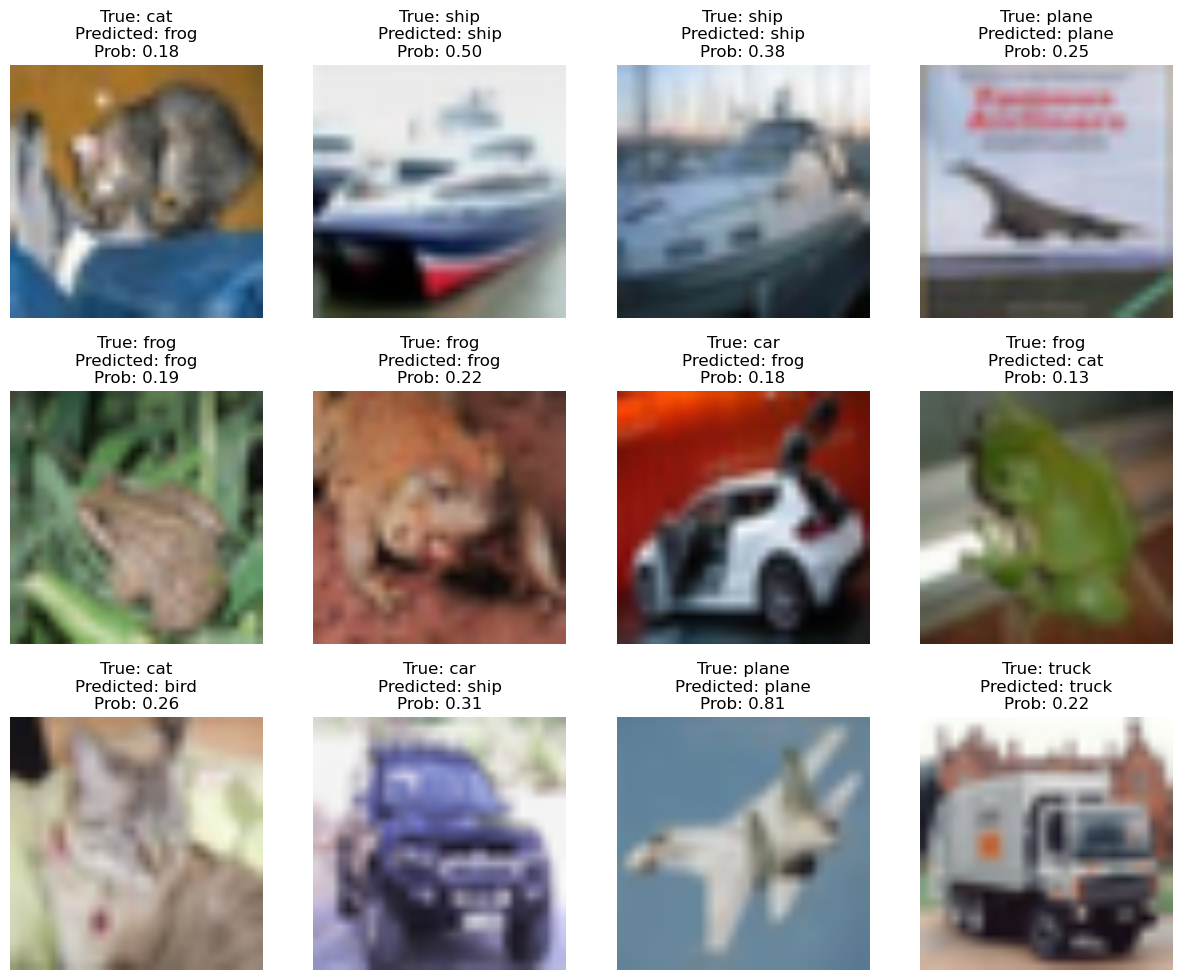

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = LinViT_model_s(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

## Strategy 2. From transformer checkpoint

save in lin_c_ckpt

In [ ]:
#Train
import os

lin_c_ckpt = r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt'

if not os.path.exists(lin_c_ckpt):
    os.makedirs(lin_c_ckpt)
    print(f"Created directory: {lin_c_ckpt}")
else:
    print(f"Directory already exists: {lin_c_ckpt}")

%cd $lin_c_ckpt

Created directory: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt


first time training from transformer checkpoint

start_epoch_trans: last epoch saved in transformer checkpoint

In [ ]:
LinViT_model_c = model.LinViT(num_classes=10, depth=12, embed_dim=768, img_size=224, patch_size=16, in_chans=3)
checkpoint_read_path = trans_ckpt_dir
checkpoint_save_path = lin_c_ckpt
num_epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LinViT_model_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, LinViT_model_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = True
)

print(f"** Start training at epoch {start_epoch_trans} from Transformer checkpoint **")

Using device: cuda
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\training_losses.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\training_speed.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 10
Step: 0, Train Loss: 2.75
Step: 100, Train Loss: 2.17
Step: 200, Train Loss: 2.19
Step: 300, Train Loss: 2.15
Step: 400, Train Loss: 2.22
Step: 500, Train Loss: 2.20
Step: 600, Train Loss: 2.14
Step: 700, Train Loss: 2.07
------------------------------
Epoch: 11/11, Train Loss: 2.21, Train Accuracy: 18.11%, Train Duration: 389.33 sec
Final checkpoint saved at C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\checkpoint_epoch_11.pth
** Start training at epoch 10 from Transformer checkpoint **


resuming from lin_c_ckpt

In [ ]:
checkpoint_read_path = lin_c_ckpt
checkpoint_save_path = lin_c_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LinViT_model_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch = tt.train_model(
    train_loader, LinViT_model_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first=False
)


Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\lin_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 11
Step: 0, Train Loss: 2.17
Step: 100, Train Loss: 2.19
Step: 200, Train Loss: 2.08
Step: 300, Train Loss: 2.07
Step: 400, Train Loss: 2.13
Step: 500, Train Loss: 2.09
Step: 600, Train Loss: 2.13
Step: 700, Train Loss: 2.08
------------------------------
Epoch: 12/21, Train Loss: 2.09, Train Accuracy: 22.78%, Train Duration: 389.07 sec
Step: 0, Train Loss: 1.95
Step: 100, Train Loss: 2.09
Step: 200, Train Loss: 2.14
Step: 300, Train Loss: 1.94
Step: 400, Train Loss: 2.11
Step: 500, Train Loss: 1.83
Step: 600, Train Loss: 2.05
Step: 700, Train Loss: 1.99
------------------------------
Epoch: 13/21, Train Loss: 2.03, Train Accuracy: 25.37%, Train D

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(LinViT_model_c, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 2.0078, Test Accuracy: 26.10%, Test Duration: 37.97 seconds
Precision: 0.26
Recall: 0.26
F1 Score: 0.25
Confusion Matrix:
[[420  68  38  28  19  30  21  43 134 199]
 [ 46 265  14  81  22  54  75  64  78 301]
 [ 95  85  73  99 167  98 163 103  24  93]
 [ 50 173  32 162  73 143 131 104  13 119]
 [ 29  66  56 102 272  94 212  64  22  83]
 [ 36 183  60 133  76 183 109 114  13  93]
 [  9  77  38 107 231  88 290  89   2  69]
 [ 22 119  43 116  70  92 106 175  23 234]
 [198 101  23  33  13  31  10  36 288 267]
 [ 47 148   9  58  13  34  37  82  90 482]]


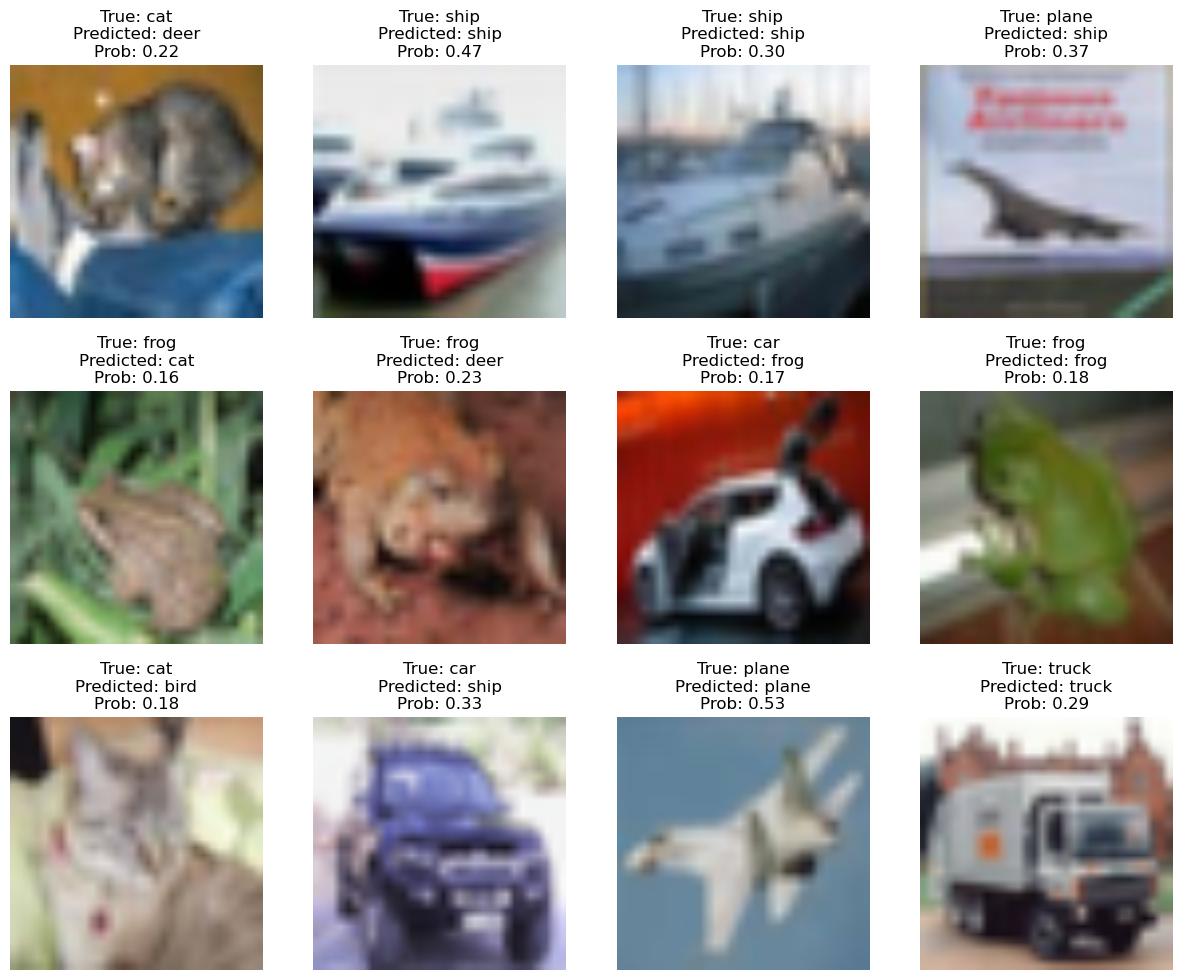

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = LinViT_model_c(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

# Performer

### a. Variant: positive random features

#### Strategy1: from  scratch

In [ ]:
import os

ViP_a_s_ckpt=r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_s_ckpt'

if not os.path.exists(ViP_a_s_ckpt):
    os.makedirs(ViP_a_s_ckpt)
    print(f"Created directory: {ViP_a_s_ckpt}")
else:
    print(f"Directory already exists: {ViP_a_s_ckpt}")

%cd $ViP_a_s_ckpt

Directory already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_s_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_s_ckpt


In [ ]:
# Train
ViP_a_s = vip.PerformerModel ( img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False,
                 atten_drop_ratio=0.,drop_ratio=0., drop_path_ratio=0.,
                 variant="a")
checkpoint_read_path =ViP_a_s_ckpt
checkpoint_save_path =ViP_a_s_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_a_s .parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, ViP_a_s , num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = False
)

Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_s_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_s_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_s_ckpt\training_accuracy.txt
No checkpoint found. Starting training from scratch.
Step: 0, Train Loss: 2.58
Step: 100, Train Loss: 2.25
Step: 200, Train Loss: 2.07
Step: 300, Train Loss: 2.20
Step: 400, Train Loss: 1.92
Step: 500, Train Loss: 1.92
Step: 600, Train Loss: 1.92
Step: 700, Train Loss: 1.73
------------------------------
Epoch: 1/10, Train Loss: 2.06, Train Accuracy: 24.21%, Train Duration: 425.81 sec
Step: 0, Train Loss: 1.83
Step: 100, Train Loss: 1.70
Step: 200, Train Loss: 1.86
Step: 300, Train Loss: 1.81
Step: 400, Train Loss: 1.67
Step: 500, Train Loss: 1.63
Step: 600, Train Loss: 1.87
Step: 700, Train Loss: 1.54
------------------------------
Epoch: 2/10, Train Loss: 1.74, Train Accur

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(ViP_a_s, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 1.0853, Test Accuracy: 61.59%, Test Duration: 38.02 seconds
Precision: 0.62
Recall: 0.62
F1 Score: 0.61
Confusion Matrix:
[[669  28  55  14  21   5  21   9 138  40]
 [ 46 701   7  15   8   1  14   6  34 168]
 [ 73   8 469  70 157  50 105  26  21  21]
 [ 30   6  74 480  87 114 130  35  19  25]
 [ 31   6 106  61 619  20 104  34  12   7]
 [ 22   7  75 276  88 384  70  52  13  13]
 [ 12  14  51  53  79  10 764   2   8   7]
 [ 24   8  47  81 120  43  26 613   8  30]
 [ 95  51  16  23  16   5   9   6 744  35]
 [ 45 111  13  25   8   2  12  21  47 716]]


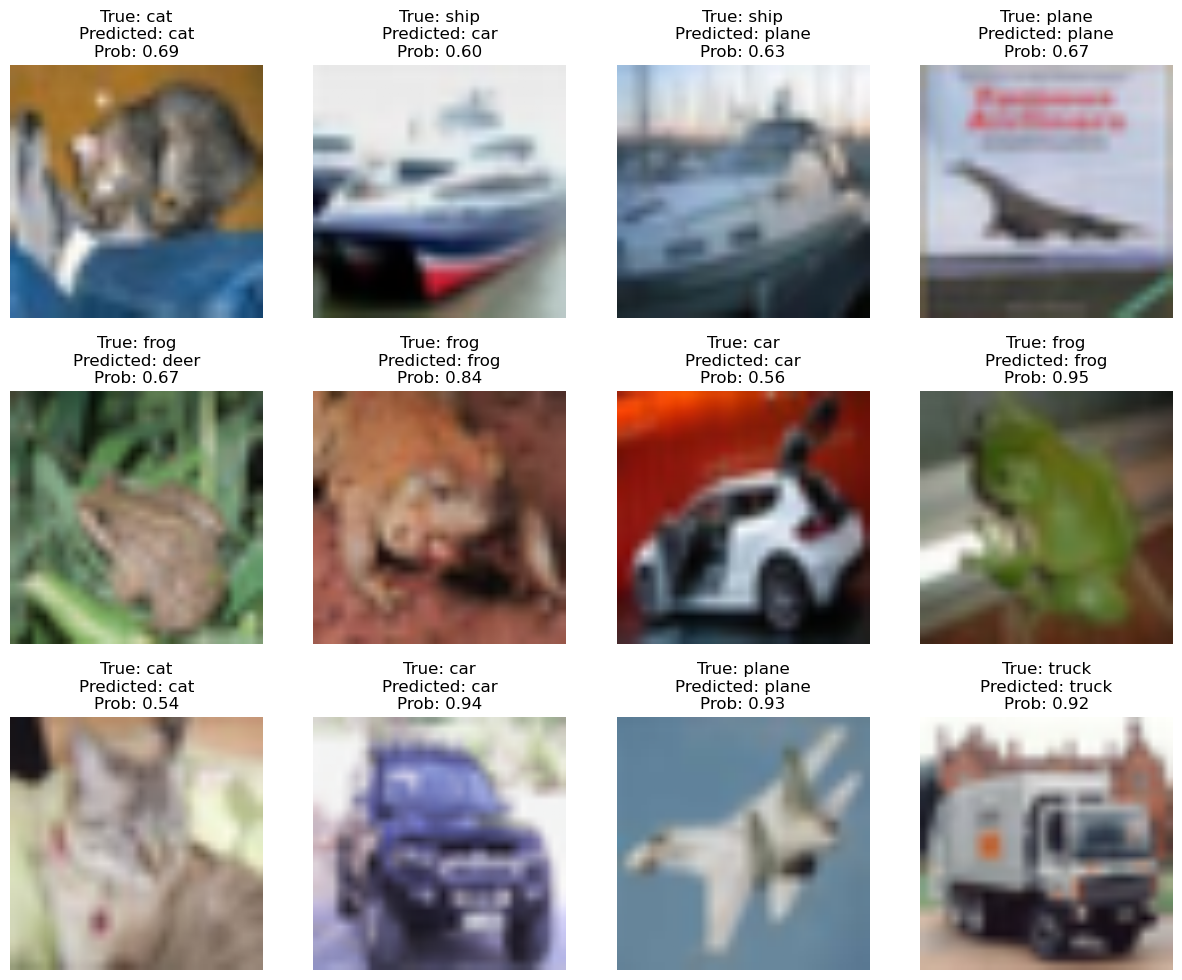

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = ViP_a_s(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

#### Strategy2: from transformer checkpoint

In [ ]:
import os

ViP_a_c_ckpt = r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt'

if not os.path.exists(ViP_a_c_ckpt):
    os.makedirs(ViP_a_c_ckpt)
    print(f"Created directory: {ViP_a_c_ckpt}")
else:
    print(f"Directory already exists: {ViP_a_c_ckpt}")

%cd $ViP_a_c_ckpt

Directory already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt


In [ ]:
#Train
ViP_a_c = vip.PerformerModel ( img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False,
                 atten_drop_ratio=0.,drop_ratio=0., drop_path_ratio=0.,
                 variant="a")
checkpoint_read_path = trans_ckpt_dir
checkpoint_save_path = ViP_a_c_ckpt
num_epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_a_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, ViP_a_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = True
)

print(f"** Start training at epoch {start_epoch_trans} from Transformer checkpoint **")

Using device: cuda
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\training_losses.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\training_speed.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 10
Step: 0, Train Loss: 2.39
Step: 100, Train Loss: 2.14
Step: 200, Train Loss: 2.08
Step: 300, Train Loss: 1.93
Step: 400, Train Loss: 1.85
Step: 500, Train Loss: 1.94
Step: 600, Train Loss: 1.93
Step: 700, Train Loss: 1.96
------------------------------
Epoch: 11/11, Train Loss: 1.99, Train Accuracy: 24.97%, Train Duration: 431.47 sec
Final checkpoint saved at C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\checkpoint_epoch_11.pth
** Start training at epoch 10 from Transformer checkpoint **


In [ ]:
checkpoint_read_path = ViP_a_c_ckpt
checkpoint_save_path = ViP_a_c_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_a_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch = tt.train_model(
    train_loader, ViP_a_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first=False
)

Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_a_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 11
Step: 0, Train Loss: 1.78
Step: 100, Train Loss: 2.10
Step: 200, Train Loss: 1.86
Step: 300, Train Loss: 2.03
Step: 400, Train Loss: 1.68
Step: 500, Train Loss: 1.74
Step: 600, Train Loss: 1.69
Step: 700, Train Loss: 1.62
------------------------------
Epoch: 12/21, Train Loss: 1.73, Train Accuracy: 36.14%, Train Duration: 431.87 sec
Step: 0, Train Loss: 1.85
Step: 100, Train Loss: 1.65
Step: 200, Train Loss: 1.55
Step: 300, Train Loss: 1.56
Step: 400, Train Loss: 2.02
Step: 500, Train Loss: 1.60
Step: 600, Train Loss: 1.53
Step: 700, Train Loss: 1.23
------------------------------
Epoch: 13/21, Train Loss: 1.58, Train Accuracy: 42.09%, T

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(ViP_a_c, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 1.1599, Test Accuracy: 58.24%, Test Duration: 38.21 seconds
Precision: 0.59
Recall: 0.58
F1 Score: 0.58
Confusion Matrix:
[[666  58  39  17  20   8  15  14 118  45]
 [ 27 794   3  15  10   3   6   5  22 115]
 [ 93  21 371  99 139  98  59  64  31  25]
 [ 29  24  39 495  65 181  51  39  27  50]
 [ 32  11  96 104 476  62  60 133  17   9]
 [ 19  14  41 264  49 463  23  76  14  37]
 [  9  17  44 161  82  49 572  26   8  32]
 [ 18  13  19  75  61  74   9 673  10  48]
 [118 116  10  18  16   9   6   3 677  27]
 [ 40 222   6  18   3   7   9  23  35 637]]


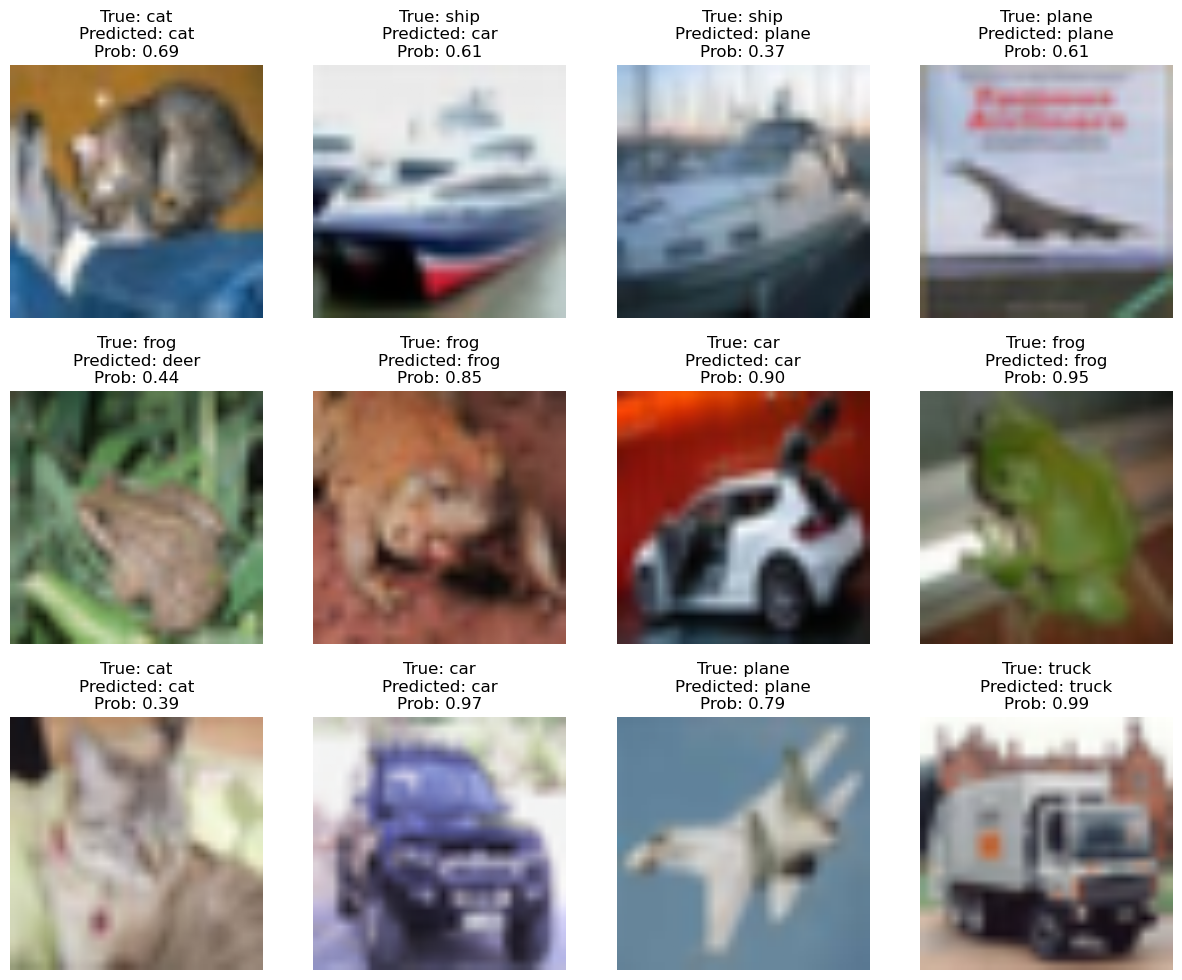

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = ViP_a_c(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

### b. Variant: ReLU  nonlinearities.

#### Strategy1: from scratch

In [ ]:
import os

ViP_relu_s_ckpt=r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_s_ckpt'

if not os.path.exists(ViP_relu_s_ckpt):
    os.makedirs(ViP_relu_s_ckpt)
    print(f"Created directory: {ViP_relu_s_ckpt}")
else:
    print(f"Directory already exists: {ViP_relu_s_ckpt}")

%cd $ViP_relu_s_ckpt

Directory already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_s_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_s_ckpt


In [ ]:
#Train
ViP_relu_s = vip.PerformerModel (img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False,
                 atten_drop_ratio=0., drop_ratio=0., drop_path_ratio=0.,
                 variant="relu")
checkpoint_read_path = ViP_relu_s_ckpt
checkpoint_save_path = ViP_relu_s_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_relu_s.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, ViP_relu_s, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = True
)

Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_s_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_s_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_s_ckpt\training_accuracy.txt
No checkpoint found. Starting training from scratch.
Step: 0, Train Loss: 2.62
Step: 100, Train Loss: 1.98
Step: 200, Train Loss: 1.88
Step: 300, Train Loss: 1.69
Step: 400, Train Loss: 1.53
Step: 500, Train Loss: 1.91
Step: 600, Train Loss: 1.73
Step: 700, Train Loss: 1.53
------------------------------
Epoch: 1/10, Train Loss: 1.76, Train Accuracy: 37.14%, Train Duration: 360.66 sec
Step: 0, Train Loss: 1.36
Step: 100, Train Loss: 1.53
Step: 200, Train Loss: 1.28
Step: 300, Train Loss: 1.50
Step: 400, Train Loss: 1.38
Step: 500, Train Loss: 1.47
Step: 600, Train Loss: 1.03
Step: 700, Train Loss: 1.30
------------------------------
Epoch: 2/10, Train Loss: 1.36, Tr

In [ ]:
# Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(ViP_relu_s, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 1.4101, Test Accuracy: 62.06%, Test Duration: 35.95 seconds
Precision: 0.63
Recall: 0.62
F1 Score: 0.62
Confusion Matrix:
[[688  39  66  19  35   6  18  13  88  28]
 [ 36 801  13  11   8   4   8   6  23  90]
 [ 64  15 525  62 140  70  65  31  16  12]
 [ 21  17  81 415 108 220  64  31  26  17]
 [ 27   8  90  46 659  49  52  51  12   6]
 [ 14  12  66 159 113 516  48  49  13  10]
 [ 18  17  86  73 125  36 623   9   6   7]
 [ 21   6  39  40 125  72  10 655  11  21]
 [108  69  24   9  18  12   8   8 710  34]
 [ 49 202  11  23  10  17   9  29  36 614]]


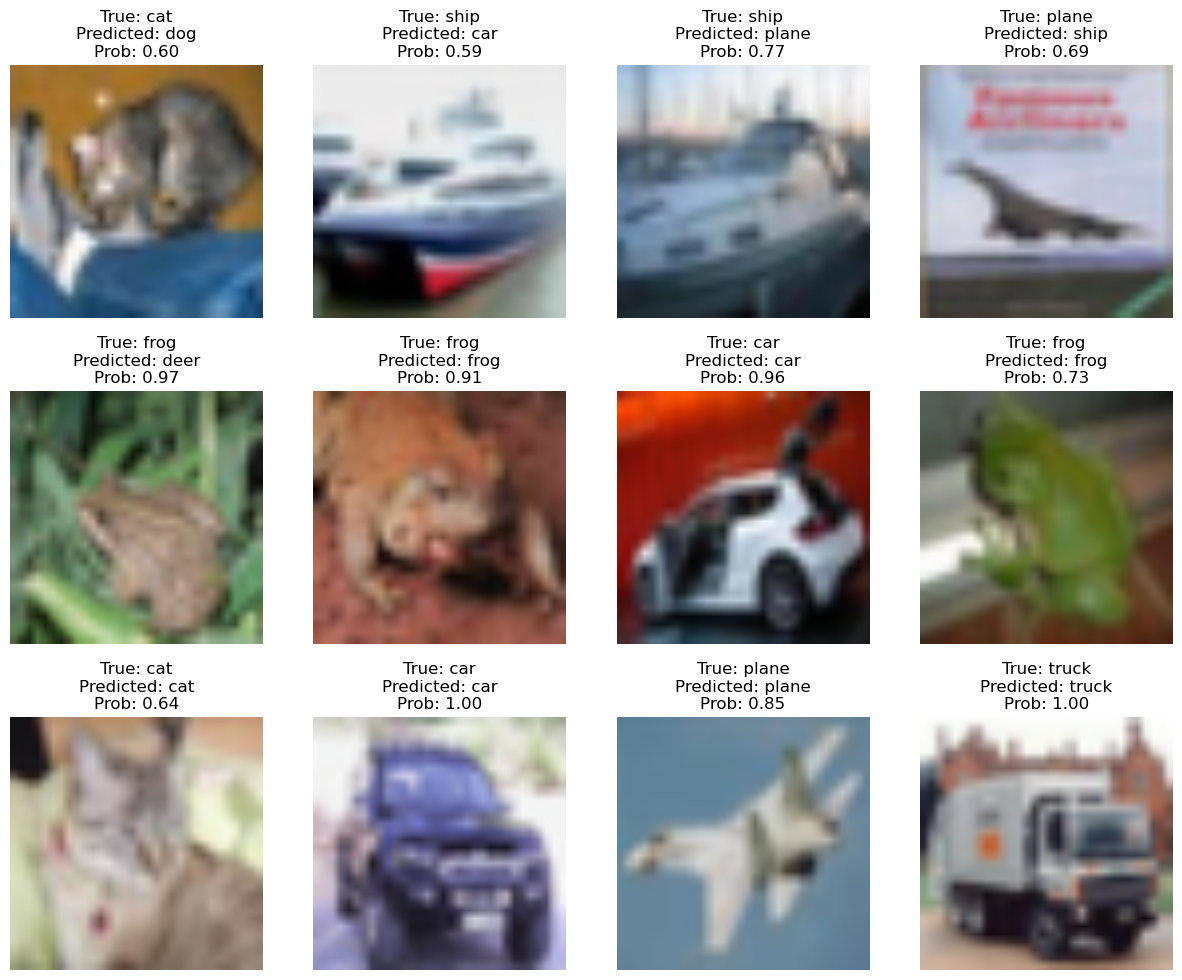

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = ViP_relu_s(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break


#### Strategy2: from transformer checkpoint

In [ ]:
#Train
import os

ViP_relu_c_ckpt = r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt'

if not os.path.exists(ViP_relu_c_ckpt):
    os.makedirs(ViP_relu_c_ckpt)
    print(f"Created directory: {ViP_relu_c_ckpt}")
else:
    print(f"Directory already exists: {ViP_relu_c_ckpt}")

%cd $ViP_relu_c_ckpt

Created directory: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt


In [ ]:
ViP_relu_c = vip.PerformerModel ( img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False,
                 atten_drop_ratio=0.,drop_ratio=0., drop_path_ratio=0.,
                 variant="relu")
checkpoint_read_path = trans_ckpt_dir
checkpoint_save_path = ViP_relu_c_ckpt
num_epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_relu_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, ViP_relu_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = True
)

print(f"** Start training at epoch {start_epoch_trans} from Transformer checkpoint **")

Using device: cuda
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\training_losses.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\training_speed.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 10
Step: 0, Train Loss: 2.34
Step: 100, Train Loss: 2.15
Step: 200, Train Loss: 1.68
Step: 300, Train Loss: 1.79
Step: 400, Train Loss: 1.57
Step: 500, Train Loss: 1.50
Step: 600, Train Loss: 1.23
Step: 700, Train Loss: 1.47
------------------------------
Epoch: 11/11, Train Loss: 1.68, Train Accuracy: 38.66%, Train Duration: 362.39 sec
Final checkpoint saved at C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\checkpoint_epoch_11.pth
** Start training at epoch 10 from Transformer checkpoint **


In [ ]:
checkpoint_read_path = ViP_relu_c_ckpt
checkpoint_save_path = ViP_relu_c_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_relu_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch = tt.train_model(
    train_loader, ViP_relu_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first=False
)

Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_relu_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 11
Step: 0, Train Loss: 1.38
Step: 100, Train Loss: 1.35
Step: 200, Train Loss: 1.37
Step: 300, Train Loss: 1.23
Step: 400, Train Loss: 1.17
Step: 500, Train Loss: 1.29
Step: 600, Train Loss: 1.37
Step: 700, Train Loss: 1.29
------------------------------
Epoch: 12/21, Train Loss: 1.30, Train Accuracy: 52.99%, Train Duration: 362.28 sec
Step: 0, Train Loss: 0.97
Step: 100, Train Loss: 1.16
Step: 200, Train Loss: 1.19
Step: 300, Train Loss: 1.12
Step: 400, Train Loss: 1.33
Step: 500, Train Loss: 1.08
Step: 600, Train Loss: 1.22
Step: 700, Train Loss: 1.00
------------------------------
Epoch: 13/21, Train Loss: 1.12, Train Accuracy: 

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(ViP_relu_c, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 1.4715, Test Accuracy: 63.71%, Test Duration: 35.28 seconds
Precision: 0.64
Recall: 0.64
F1 Score: 0.64
Confusion Matrix:
[[700  21  71  14  18  10  12  12  90  52]
 [ 17 735  10  13   5  11  11   3  52 143]
 [ 63   4 518  65  99  96  92  28  19  16]
 [ 19  14  54 433  60 254  95  31  16  24]
 [ 25   6 121  55 509  86 108  63  16  11]
 [ 15   9  57 169  57 583  43  46  11  10]
 [  7   5  41  64  42  47 769  10   6   9]
 [ 20   7  37  43  83 128  17 632   5  28]
 [ 83  38  18  18  13  16  12   4 754  44]
 [ 24  95  10  29  12  24  14  17  37 738]]


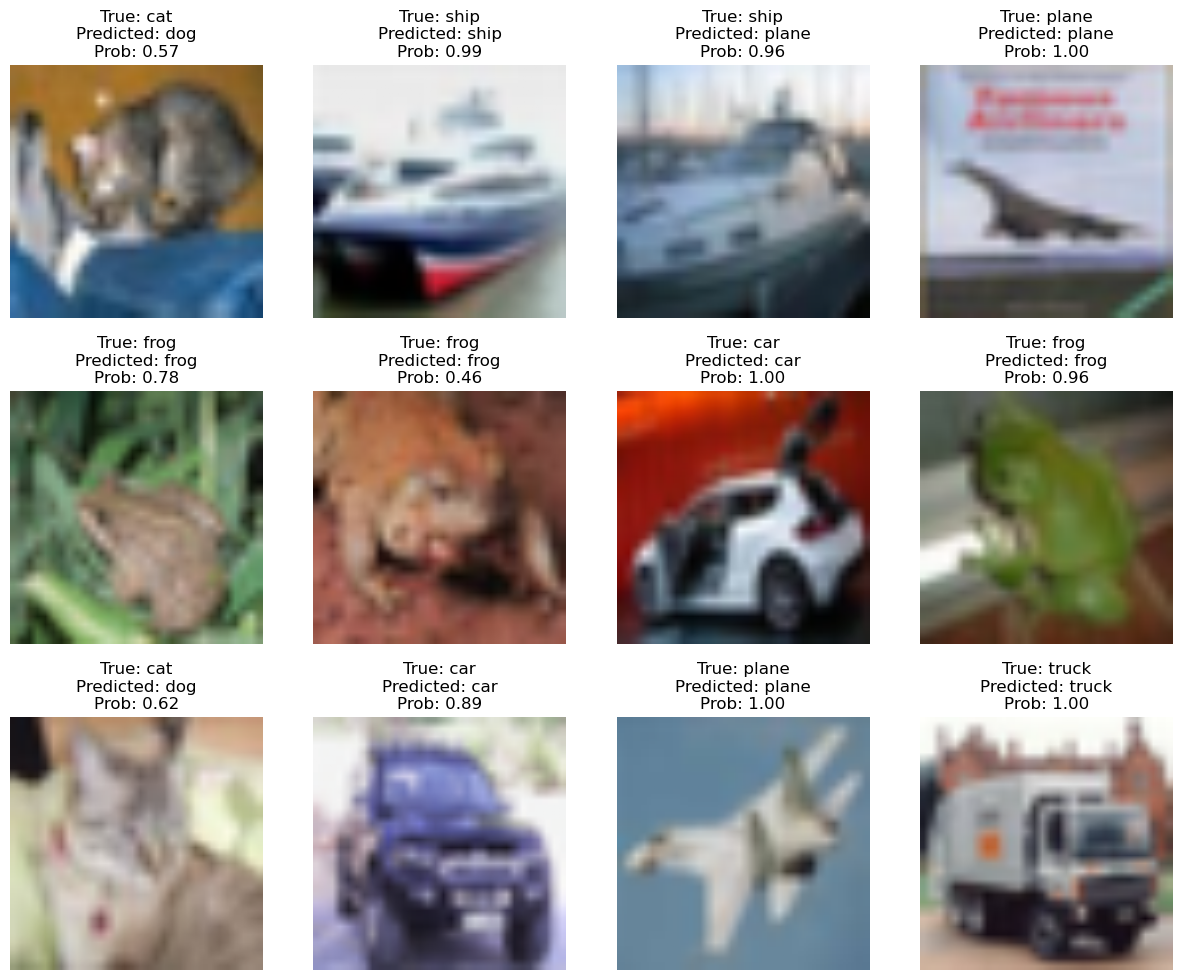

In [ ]:

for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = ViP_relu_c(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

### b: Variant: EXP

#### Strategy1: from scratch

In [ ]:
import os

ViP_exp_s_ckpt=r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_s_ckpt'

if not os.path.exists(ViP_exp_s_ckpt):
    os.makedirs(ViP_exp_s_ckpt)
    print(f"Created directory: {ViP_exp_s_ckpt}")
else:
    print(f"Directory already exists: {ViP_exp_s_ckpt}")

%cd $ViP_exp_s_ckpt

Directory already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_s_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_s_ckpt


In [ ]:
ViP_exp_s =vip.PerformerModel (img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False,
                 atten_drop_ratio=0., drop_ratio=0., drop_path_ratio=0.,
                 variant="exp")
checkpoint_read_path = ViP_exp_s_ckpt
checkpoint_save_path = ViP_exp_s_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_exp_s.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, ViP_exp_s, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = False
)

Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_s_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_s_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_s_ckpt\training_accuracy.txt
No checkpoint found. Starting training from scratch.
Step: 0, Train Loss: 2.51
Step: 100, Train Loss: 2.08
Step: 200, Train Loss: 1.82
Step: 300, Train Loss: 1.72
Step: 400, Train Loss: 1.54
Step: 500, Train Loss: 1.80
Step: 600, Train Loss: 1.62
Step: 700, Train Loss: 1.59
------------------------------
Epoch: 1/10, Train Loss: 1.74, Train Accuracy: 37.73%, Train Duration: 367.49 sec
Step: 0, Train Loss: 1.18
Step: 100, Train Loss: 1.69
Step: 200, Train Loss: 1.23
Step: 300, Train Loss: 1.58
Step: 400, Train Loss: 1.25
Step: 500, Train Loss: 1.27
Step: 600, Train Loss: 1.43
Step: 700, Train Loss: 1.19
------------------------------
Epoch: 2/10, Train Loss: 1.37, Train

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(ViP_exp_s, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 1.3866, Test Accuracy: 60.80%, Test Duration: 35.65 seconds
Precision: 0.61
Recall: 0.61
F1 Score: 0.61
Confusion Matrix:
[[695  15  50  23  15   8  18  12 119  45]
 [ 37 615  15  17  10   9   2  13  70 212]
 [ 76  14 469  65 110 100  66  58  13  29]
 [ 33  18  68 383  56 260  73  52  22  35]
 [ 41   6  93  41 558  72  62  97  17  13]
 [ 13   9  77 172  63 534  44  55   9  24]
 [ 11  17  67  68  77  60 659  15   4  22]
 [ 41  15  27  41  71  66  17 682   6  34]
 [ 94  40  18  16  13  18   6   9 752  34]
 [ 43  94   9  28   4  15   8  16  50 733]]


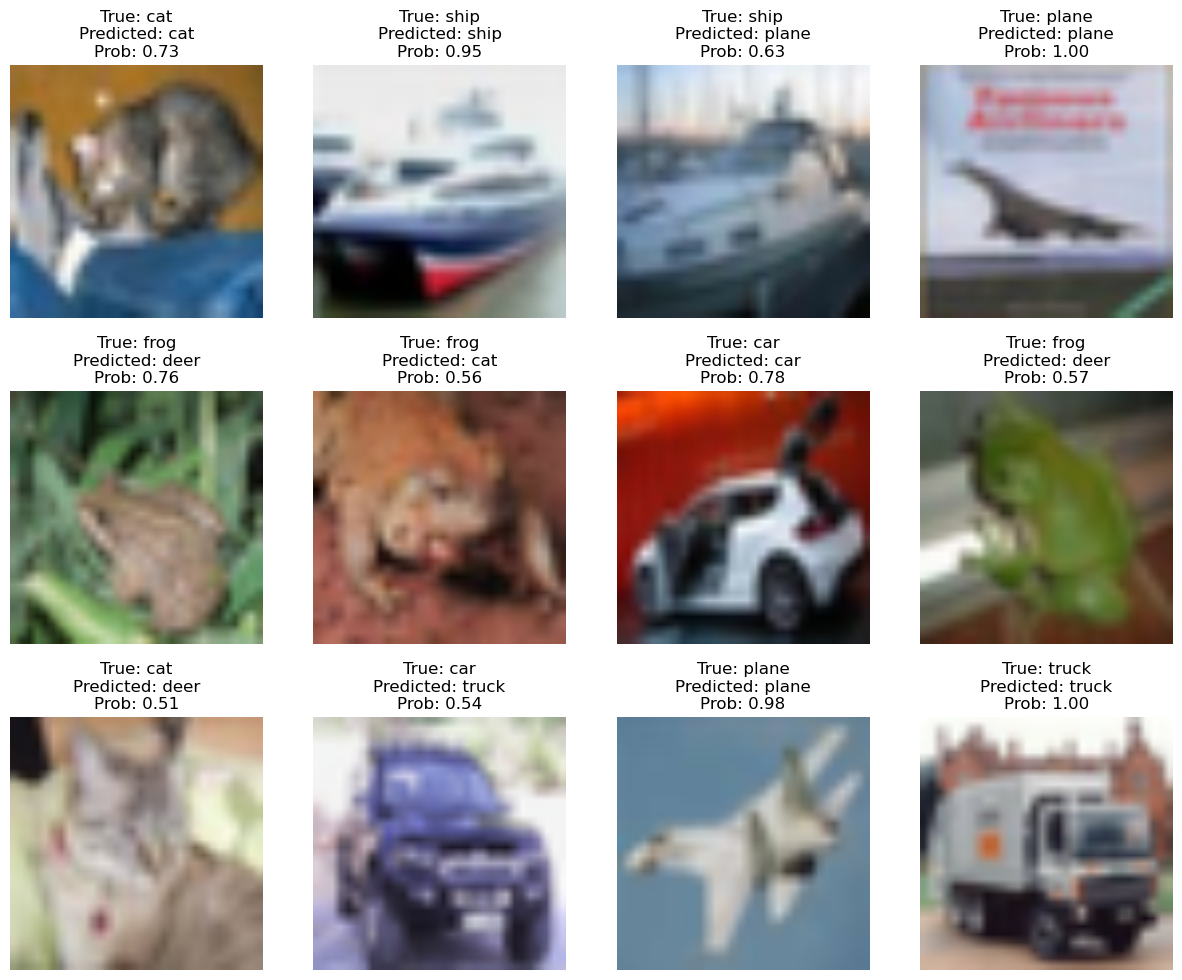

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = ViP_exp_s(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

#### Strategy2: from transformer checkpoint

In [ ]:
import os

ViP_exp_c_ckpt = r'C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt'

if not os.path.exists(ViP_exp_c_ckpt):
    os.makedirs(ViP_exp_c_ckpt)
    print(f"Created directory: {ViP_exp_c_ckpt}")
else:
    print(f"Directory already exists: {ViP_exp_c_ckpt}")

%cd $ViP_exp_c_ckpt

Created directory: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt
C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt


In [ ]:
ViP_exp_c = vip.PerformerModel ( img_size=224, patch_size=16, in_chans=3, num_classes=10, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False,
                 atten_drop_ratio=0.,drop_ratio=0., drop_path_ratio=0.,
                 variant="exp")
checkpoint_read_path = trans_ckpt_dir
checkpoint_save_path = ViP_exp_c_ckpt
num_epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_exp_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch_trans = tt.train_model(
    train_loader, ViP_exp_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first = True
)

print(f"** Start training at epoch {start_epoch_trans} from Transformer checkpoint **")

Using device: cuda
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\training_losses.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\training_speed.txt
File created: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 10
Step: 0, Train Loss: 2.29
Step: 100, Train Loss: 1.99
Step: 200, Train Loss: 2.04
Step: 300, Train Loss: 1.70
Step: 400, Train Loss: 1.50
Step: 500, Train Loss: 1.78
Step: 600, Train Loss: 1.50
Step: 700, Train Loss: 1.26
------------------------------
Epoch: 11/11, Train Loss: 1.67, Train Accuracy: 39.38%, Train Duration: 367.21 sec
Final checkpoint saved at C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\checkpoint_epoch_11.pth
** Start training at epoch 10 from Transformer checkpoint **


In [ ]:
checkpoint_read_path = ViP_exp_c_ckpt
checkpoint_save_path = ViP_exp_c_ckpt
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ViP_exp_c.parameters(), lr=0.001)

train_losses_lc, train_speed_lc, train_accuracy_lc, start_epoch = tt.train_model(
    train_loader, ViP_exp_c, num_epochs,criterion, optimizer,
    checkpoint_read_path, checkpoint_save_path,
    save_checkpoint=True, first=False
)

Using device: cuda
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\training_losses.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\training_speed.txt
File already exists: C:\Users\Administrator\Desktop\yyg\IEOR 4540\ViP_exp_c_ckpt\training_accuracy.txt
Resuming from checkpoint at epoch 11
Step: 0, Train Loss: 1.36
Step: 100, Train Loss: 1.42
Step: 200, Train Loss: 1.29
Step: 300, Train Loss: 1.17
Step: 400, Train Loss: 1.41
Step: 500, Train Loss: 1.29
Step: 600, Train Loss: 1.25
Step: 700, Train Loss: 1.24
------------------------------
Epoch: 12/21, Train Loss: 1.31, Train Accuracy: 52.85%, Train Duration: 367.10 sec
Step: 0, Train Loss: 1.09
Step: 100, Train Loss: 1.26
Step: 200, Train Loss: 1.25
Step: 300, Train Loss: 1.17
Step: 400, Train Loss: 1.27
Step: 500, Train Loss: 1.18
Step: 600, Train Loss: 1.23
Step: 700, Train Loss: 1.55
------------------------------
Epoch: 13/21, Train Loss: 1.15, Train Accuracy: 58.

In [ ]:
#Test
mean = torch.tensor([0.486, 0.485, 0.484])
std = torch.tensor([0.226, 0.225, 0.224])

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loss, test_accuracy, predictions, labels,test_duration = tt.evaluate_model(ViP_exp_c, test_loader, criterion,device)

all_preds = torch.tensor(predictions).to('cpu')
all_labels = torch.tensor(labels).to('cpu')

precision = precision_score(all_labels.numpy(), all_preds.numpy(), average='macro')
recall = recall_score(all_labels.numpy(), all_preds.numpy(), average='macro')
f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average='macro')
confusion = confusion_matrix(all_labels.numpy(), all_preds.numpy())

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Duration: {test_duration:.2f} seconds")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

Using device: cuda
Test Loss: 1.3686, Test Accuracy: 63.05%, Test Duration: 35.43 seconds
Precision: 0.63
Recall: 0.63
F1 Score: 0.63
Confusion Matrix:
[[723  30  64  15  19  12   7  14  75  41]
 [ 38 709  11  13   9  12  10  10  40 148]
 [ 61  10 532  71 108  68  77  43  15  15]
 [ 24  14  90 402 100 197  75  48  22  28]
 [ 22   9  93  55 624  40  64  70  15   8]
 [ 17   6  77 167  66 541  43  64  11   8]
 [  8   8  61  81  75  49 683  10  13  12]
 [ 33   7  51  39  82  75  13 671   5  24]
 [111  53  27  11  22  15   4  10 708  39]
 [ 50 115  12  20   8  12   8  27  36 712]]


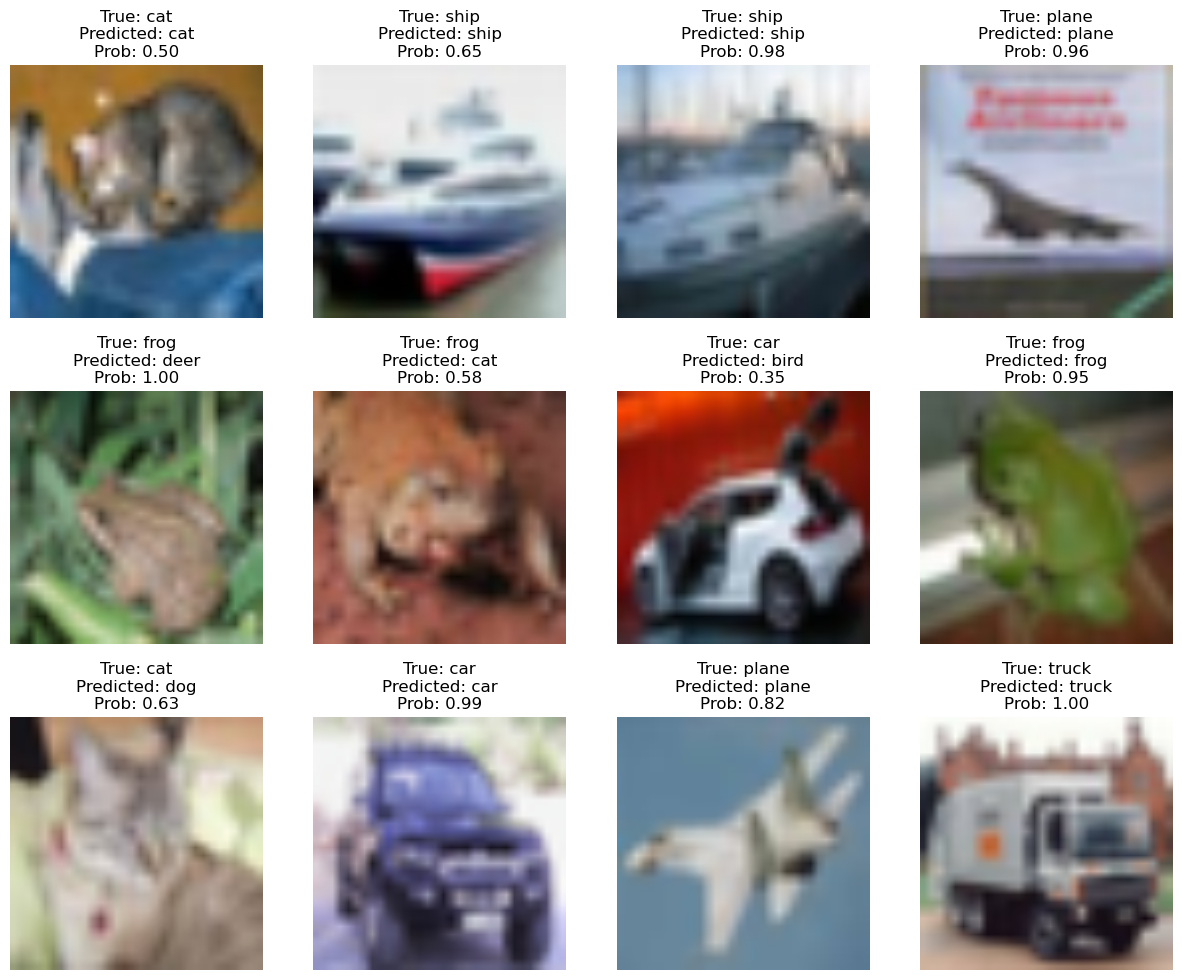

In [ ]:
for images, labels in test_loader:
    images, labels = images[:12], labels[:12]
    with torch.no_grad():
        outputs = ViP_exp_c(images.to(device))
        _, predicted = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)
        top_p, top_class = probs.topk(1, dim=1)
    tt.plot_images(images, labels, predicted, top_p.squeeze(), mean, std)
    break

# Code Citation

* https://github.com/google-research/google-research

* https://github.com/lucidrains/performer-pytorch

* https://blog.csdn.net/dgvv4/article/details/125184340

* https://blog.csdn.net/qq_37937847/article/details/115547107

* https://www.kaggle.com/code/fymwin/vision-transformer